In this Python notebook, we will be employing transfer learning techniques to train existing models (AlexNet, VGG, ResNet and DenseNet). The process will be divided into two main parts:

Feature Extraction: In the first part, we will utilize the models as fixed feature extractors. This involves modifying only the last fully connected (FC) layer of each model to suit our specific task and training just this layer while keeping the rest of the model unchanged.

Fine-Tuning: In the second part, we will implement fine-tuning, which involves training all the layers of the model on our dataset, starting from the pretrained weights. We will specifically apply this approach to AlexNet.

### <img src="icons/resized/library.png" style="height:50px;display:inline"> Libs

Import libraries for the project:

In [5]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
import time
import copy
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt

### <img src="icons/resized/dataset.png" style="height:50px;display:inline"> Dataset
Load the training and validation datasets and convert them into data loaders. Apply transformations to resize the images to 224x224 and normalize them.

In [6]:
# create train dataloader and valid dataloader
def add_gaussian_noise_tensor(tensor, mean=0, std=0.02):
    noise = torch.randn_like(tensor) * std + mean
    noisy_tensor = tensor + noise
    return noisy_tensor

def set_transform(add_noise=False):
  train_transform = transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  valid_transform = transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
  
  if add_noise:
    # Define the mean and standard deviation for Gaussian noise
    mean_value = 0  # Mean of the Gaussian noise
    std_value = 0.05  # Standard deviation of the Gaussian noise
    # Define the transform function using transforms.Lambda
    noisy_transform = transforms.Compose([
        transforms.Lambda(lambda x: add_gaussian_noise_tensor(x, mean=mean_value, std=std_value)),  # Add Gaussian noise to 
    ])
    
    train_transform = transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      noisy_transform,
    ])

    valid_transform = transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      noisy_transform,
    ])
  return train_transform, valid_transform

def create_dataloader(root_dir, batch_size, add_noise=False):
  train_transform, valid_transform = set_transform(add_noise)
  # Create datasets
  train_dataset = ImageFolder(root=root_dir + '/train', transform=train_transform)
  valid_dataset = ImageFolder(root=root_dir + '/val', transform=valid_transform)
  if add_noise:
      num_workers = 0
  else:
      num_workers = 2
  print(num_workers)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
  dataloaders = {'train' : train_loader, 'val' : valid_loader}
  return dataloaders

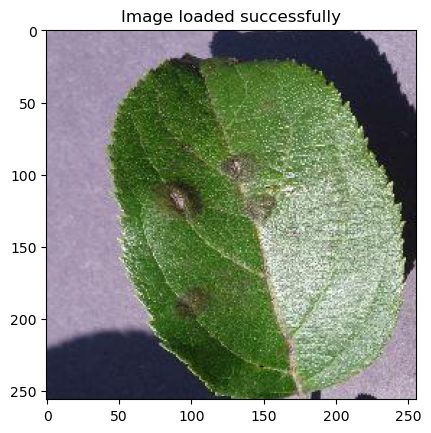

In [10]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

def normalize(image, device=torch.device("cpu")):
    #normalize = transforms.Normalize(
    #mean=[0.485, 0.456, 0.406],
    #std=[0.229, 0.224, 0.225]
    #)
    preprocess = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(), ])
    #normalize])

    if isinstance(image, torch.Tensor):
        # Convert the tensor to PIL Image
        image = transforms.ToPILImage()(image)
    image = preprocess(image).unsqueeze(0).to(device)
    return image

def predict(image, model, labels=None):
    _, index = model(image).data[0].max(0)
    if labels is not None:
        return str(index.item()), labels[str(index.item())][1]
    else:
        return str(index.item())

def deprocess(image, device=torch.device("cpu")):
    return image * torch.tensor([0.229, 0.224, 0.225]).to(device) + torch.tensor([0.485, 0.456, 0.406]).to(device)

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

dir_label = 'Apple___Apple_scab'
local_root_dir = r'/Users/noambuzaglo/Desktop/lilush/PlantVillage'

sample_image = load_image((local_root_dir + '/test/' + dir_label + '/2a97b29d-8a63-47ab-bd5b-c14832a586c8___FREC_Scab 3242.JPG'))

### <img src="icons/resized/helper_functions.png" style="height:50px;display:inline"> Useful Functions
set_parameter_requires_grad: Sets parameter requirements for gradient computation based on feature extraction mode.
initialize_model: Initializes a model for transfer learning with customizable settings.
params_to_update: Identifies parameters to be updated during training based on feature extraction mode.
train_model: Trains and validates a PyTorch model, returning results including accuracy and loss.
calculate_accuracy: Calculates the accuracy of a PyTorch model on a given test dataset, along with a confusion matrix.

In [3]:
def set_parameter_requires_grad(model, feature_extracting=False):
    """
    Sets the .requires_grad attribute of the parameters in the model. This is used to freeze or unfreeze
    the model's parameters during training.

    Parameters:
    - model (torch.nn.Module): The model whose parameters will be modified.
    - feature_extracting (bool): If True, the model is being used for feature extraction, and all
      parameters are frozen to prevent gradients from being computed. If False, the model will be fine-tuned,
      and gradients will be computed for all parameters.

    If feature_extracting is True, this function goes through all parameters in the model and sets
    .requires_grad to False, effectively freezing the model during training. This is useful when you're only
    interested in training a few top layers of a model while keeping the rest unchanged.

    Conversely, if feature_extracting is False, this indicates that the model will undergo fine-tuning,
    where all model parameters are subject to training. Therefore, it sets .requires_grad to True for all
    parameters, allowing gradients to be computed and weights to be updated during training.
    """
    if feature_extracting:
        # Freeze all parameters for feature extraction
        for param in model.parameters():
            param.requires_grad = False
    else:
        # Unfreeze all parameters for fine-tuning
        for param in model.parameters():
            param.requires_grad = True


In [4]:
import torchvision.models as models
import torch.nn as nn

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True, set_lora=False):
    """
    Initializes a model for transfer learning based on the specified architecture (model_name).
    This function can adjust models for a new task by changing their output layers to match
    the number of classes for the new task (num_classes). It supports operating in either
    feature extraction or fine-tuning mode.

    Parameters:
    - model_name (str): The name of the model architecture to be initialized.
    - num_classes (int): The number of classes for the new task.
    - feature_extract (bool): If True, the model is set to feature extraction mode where only the final layer's parameters are updated.
    - use_pretrained (bool): If True, initializes the model with weights pre-trained on ImageNet.
    - set_lora (bool): Placeholder for future use, not implemented in this function.

    Returns:
    - model_ft (torch.nn.Module): The initialized model ready for training on the new task.
    - input_size (int): The required input image size for the model, e.g., 224 for AlexNet.
    """

    # Initialize variables for the model and input size.
    model_ft = None
    input_size = 0

    # Define weights setting based on whether pretrained weights are desired.
    weights = 'DEFAULT' if use_pretrained else None

    if model_name == "resnet":
        # Initialize ResNet
        model_ft = models.resnet18(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        # Initialize AlexNet
        model_ft = models.alexnet(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        # Initialize VGG
        model_ft = models.vgg16(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "densenet":
        # Initialize DenseNet
        model_ft = models.densenet121(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        # Note: DenseNet's input size is often larger in practice, but 224 works for compatibility.
        input_size = 224

    else:
        raise NotImplementedError("The specified model name is not supported.")

    return model_ft, input_size

In [5]:
def params_to_update(model, feature_extract):
    """
    Identifies and returns the parameters to be optimized/updated in this run. If we are
    fine-tuning, we will update all parameters. However, if we are using the feature extraction
    method, we will only update the parameters that were recently initialized, i.e., the parameters
    for which requires_grad is True.

    Parameters:
    - model (torch.nn.Module): The model for which parameters are to be identified.
    - feature_extract (bool): Flag indicating whether we are feature extracting. If True, only parameters
      that require gradients are updated; otherwise, all parameters are updated.

    Returns:
    - params_to_update (list of torch.nn.parameter.Parameter): A list of parameters that will be updated.
    """
    if feature_extract:
        params_to_update = []
        print("Params to learn:")
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        # In the case of fine-tuning, we consider all parameters for updates,
        # but still filter them based on requires_grad to be consistent with the condition.
        # This allows the function to be flexible for models where some parameters might explicitly be frozen.
        params_to_update = [param for param in model.parameters() if param.requires_grad]
        print("Params to learn:")
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)

    return params_to_update


In [6]:
def train_model(model, model_name, dataloaders, criterion, optimizer, num_epochs=25, set_lora=False):
    """
    Train and validate a PyTorch model.

    Parameters:
    - model: The model to be trained and validated.
    - model_name: Name of the model, used for saving checkpoints.
    - dataloaders: A dictionary containing 'train' and 'val' DataLoaders for loading the data.
    - criterion: The loss function.
    - optimizer: The optimization algorithm.
    - num_epochs (int): The number of epochs to train the model.
    - set_lora (bool): Flag for potential future use, not used in the current implementation.

    Returns:
    - model: The trained model.
    - results: A df with validation accuracy, validation loss, rtain accuracy and train loss for each epoch.
    """

    since = time.time()

    # Store the original model parameters to restore later if needed.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    results_list = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch goes through both training and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data in batches.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # Track history if in train phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Backward pass and optimize if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            epoch_acc = epoch_acc.cpu().numpy()  # Convert tensor to CPU
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            results_list.append(pd.DataFrame({'phase': [phase], 'epoch': [epoch], 'loss': [epoch_loss], 'accuracy': [epoch_acc.item()]}))

            # Save the model if it has the best validation accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Print out the training time and best validation accuracy
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    results = pd.concat(results_list, ignore_index=True)

    # Load best model weights and save the model checkpoint
    model.load_state_dict(best_model_wts)
    if not os.path.isdir('checkpoints'):
        os.mkdir('checkpoints')
    torch.save({'net': model.state_dict()}, f'./checkpoints/{model_name}.pth')

    return model, results


In [7]:
def calculate_accuracy(model, dataloader, device):
    """
    Calculate the accuracy of a PyTorch model on a given dataset.

    Parameters:
    - model (torch.nn.Module): The model to evaluate.
    - dataloader (torch.utils.data.DataLoader): DataLoader for the dataset to evaluate the model on.
    - device (torch.device): The device on which to perform the calculations (e.g., 'cuda' or 'cpu').

    Returns:
    - model_accuracy (float): The accuracy of the model on the dataset as a percentage.
    - confusion_matrix (np.array): A confusion matrix of size [num_classes, num_classes], where
      num_classes is the number of unique labels in the dataset. The matrix is used to evaluate
      the model's performance across different classes.
    """

    # Switch the model to evaluation mode to deactivate Dropout and use learned statistics in BatchNorm.
    model.eval()

    total_correct = 0
    total_images = 0
    # Assuming a maximum of 38 classes - adjust the size according to your specific task.
    confusion_matrix = np.zeros([38, 38], int)

    with torch.no_grad():  # Disable gradient computation for efficiency
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass to get the model's predictions
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Update total images and correctly predicted counts
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            # Update confusion matrix
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1

    # Calculate accuracy as the percentage of correct predictions
    model_accuracy = total_correct / total_images * 100

    return model_accuracy, confusion_matrix

### <img src="icons/resized/device.png" style="height:50px;display:inline"> Device
Define the device:

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_built():
    print("using MPS")
    device = torch.device("mps")

using MPS


### <img src="icons/resized/training.png" style="height:50px;display:inline">  Train

Create a function that initializes models based on the chosen parameters, allowing the selection of either feature extraction or fine-tuning. This function should also train the models and print the results on each epoch.

In [13]:
def set_and_run_model(root_dir, model_name, file_name, feature_extract, add_noise=False):
    """
    Set up and run the model with the specified configurations.

    Args:
        root_dir (str): The root directory of the dataset.
        model_name (str): Name of the model to be used (e.g., 'resnet', 'alexnet', 'vgg', 'densenet').
        file_name (str): Name of the file to save the results.
        feature_extract (bool): Flag for feature extraction.
                                When False, fine-tune the whole model.
                                When True, update only the reshaped layer parameters.

    Returns:
        model_ft: The trained model.
    """
    root_dir = root_dir
    batch_size = 128
    dataloaders = create_dataloader(root_dir, batch_size, add_noise)
    # Models to choose from [resnet, alexnet, vgg, densenet]
    model_name = model_name
    # Number of classes in the dataset
    num_classes = 38
    # Batch size for training (change depending on how much memory you have)
    batch_size = 32
    # Number of epochs to train for
    num_epochs = 15
    # Flag for feature extracting. When False, we fine-tune the whole model,
    # when True we only update the reshaped layer params
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    # Print the model we just instantiated
    print(model_ft)
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    updated_params = params_to_update(model_ft, feature_extract)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.backends.mps.is_built():
        print("using MPS")
        device = torch.device("mps")
    model_ft = model_ft.to(device)
    optimizer_ft = torch.optim.Adam(updated_params, lr=0.0002)
    # Setup the loss fn
    criterion = nn.CrossEntropyLoss()
    # Train and evaluate
    model_ft, results = train_model(model_ft, model_name, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)
    results.to_csv(f"results_{file_name}.csv", index=False)
    return model_ft

### <img src="icons/resized/test.png" style="height:50px;display:inline">  Test
Verify the accuracy of the model using the test dataset.

In [19]:
def run_test_data(root_dir, model, std_noise=None):
    """
    Run the test data on the trained model and calculate the test accuracy.

    Args:
        root_dir (str): The root directory of the dataset.
        model: The trained model.
        batch_size (int): Batch size for loading the test data.

    Returns:
        float: Test accuracy.
    """    
    if std_noise:
        mean_value = 0  # Mean of the Gaussian noise
        std_value = std_noise # Standard deviation of the Gaussian noise
    
        # Define the transform function using transforms.Lambda
        noisy_transform = transforms.Compose([
        transforms.Lambda(lambda x: add_gaussian_noise_tensor(x, mean=mean_value, std=std_value)),  # Add Gaussian noise to 
        ])
        test_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        noisy_transform,
        ])
        num_workers = 0
    else: 
        test_transform = transforms.Compose([
          transforms.RandomResizedCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),

      ])
        num_workers = 2
    
    batch_size = 128    
    test_dataset = ImageFolder(root=root_dir + '/test', transform=test_transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    test_accuracy, _ = calculate_accuracy(model, test_loader, device)
    print(f"test accuracy:{test_accuracy}")

In [11]:
root_dir = r'/Users/noambuzaglo/Desktop/lilush/PlantVillage'

### <img src="icons/resized/feture extract.png" style="height:50px;display:inline">  Feature extract
Train and evaluate all selected pre-trained models using feature extraction: AlexNet, VGG, ResNet, DenseNet

In [ ]:
# vgg with feature extract
vgg_feature_extract = set_and_run_model(root_dir, 'vgg', 'vgg_feature_extract', True)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
run_test_data(root_dir, vgg_feature_extract)

test accuracy:84.75046210720888


In [ ]:
# alexnet with feature extract
alexnet_feature_extract = set_and_run_model(root_dir, 'alexnet', 'alexnet_feature_extract', True)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
run_test_data(root_dir, alexnet_feature_extract)

test accuracy:84.84288354898337


In [ ]:
# densenet with feature extract
densenet_feature_extract = set_and_run_model(root_dir, 'densenet', 'densenet_feature_extract', True)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
run_test_data(root_dir, densenet_feature_extract)

test accuracy:88.56284658040666


In [ ]:
# resnet with feature extract
resnet_feature_extract = set_and_run_model(root_dir, 'resnet', 'resnet_feature_extract', True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
run_test_data(root_dir, resnet_feature_extract)

test accuracy:86.87615526802219


### <img src="icons/resized/tuning.png" style="height:50px;display:inline">  Fine tuning
Train and evaluate pre-trained models using fine-tuning: AlexNet, ResNet

In [ ]:
# alexnet with fine-tuning
alexnet_fine_tuning = set_and_run_model(root_dir, 'alexnet', 'alexnet_fine-tuning', False)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
run_test_data(root_dir, alexnet_fine_tuning)

test accuracy:96.85767097966729


In [ ]:
# resnet with fine-tuning
resnet_fine_tuning = set_and_run_model(root_dir, 'resnet', 'resnet_fine-tuning', False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
run_test_data(root_dir, resnet_fine_tuning)

test accuracy:97.98983364140481


### <img src="icons/resized/noise.png" style="height:50px;display:inline">  Add Noise
Train AlexNet using fine-tuning with a noisy dataset (Gaussian noise) and evaluate the test accuracy on the noisy test dataset across a range of noise levels.

In [15]:
alexnet_fine_tuning_with_noise = set_and_run_model(root_dir, 'alexnet', 'alexnet_fine-tuning_with_noise', False, add_noise=True)

0
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)

In [21]:
std_noises = [0, 0.05, 0.07, 0.09]
for noise in std_noises:
    print(f"std noise = {noise}")
    run_test_data(root_dir, alexnet_fine_tuning_with_noise, std_noise=noise)


std noise = 0
test accuracy:96.69593345656192
std noise = 0.05
test accuracy:97.01940850277265
std noise = 0.07
test accuracy:97.08872458410352
std noise = 0.09
test accuracy:96.9731977818854
